# An analysis of the State of the Union speeches - Part 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
from nltk import punkt, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [2]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [3]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [4]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [5]:
def tokenize_word(doc):
    """word tokenizer
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    tokens = [token.lower() for token in word_tokenize(doc)]
    return tokens

In [6]:
def clean_word_tokenize(doc):
    """custom word toenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    stop = stopwords.words("english") + list(punctuation)
    tokens = [token.lower() for token in word_tokenize(doc)
              if token not in stop]
    return tokens

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [7]:
n_sent = []
n_words_all=[]
n_uwords=[]
n_chars = []
n_words=[]
n_swords=[]
stemmer = SnowballStemmer('english')
speeches_cleaned = []
speech_words = []
# go through our list of speeches and compute these metrics for each speech
for speech in speeches:
    stemmed = []
    #all characters in speech
    n_chars.append(len(speech))
    #unique words before removing stop words and punctuation
    tokens_all = tokenize_word(speech)
    tokens_all_counter = Counter(tokens_all)
    #number of sentences
    sent_tokens = sent_tokenize(speech)
    n_sent.append(len(sent_tokens))
    #add all words before removing stop words and punctuation
    n_words_all.append(len(tokens_all))
    
    #words with stop words and punctuation removed
    tokens = clean_word_tokenize(speech)
    tokens_counter = Counter(tokens)
    n_words.append(len(tokens))
    #unique words with stop words and punctuation removed
    n_uwords.append(len(tokens_counter.values()))
    
    #stemmed words
    for token in tokens:
        s = stemmer.stem(token.lower())
        stemmed.append(s)
    #unique, stemmed words
    stemmed_counter = Counter(stemmed)
    #save our unique stemmed words into speech_words for later use
    speech_words.append(list(stemmed_counter.keys()))
    #save our stemmed (non-unique) words into speeches_cleaned for later use
    speeches_cleaned.append(stemmed)
    #number of unique stemmed words
    n_swords.append(len(stemmed_counter))

#save these values into our addresses dataframe
addresses['n_sent'] = pd.Series(n_sent)
addresses['n_words_all'] = pd.Series(n_words_all) 
addresses['n_words'] = pd.Series(n_words)
addresses['n_uwords'] = pd.Series(n_uwords)
addresses['n_swords'] = pd.Series(n_swords)
addresses['n_chars'] = pd.Series(n_chars)

In [8]:
#a look at our updated dataframe
pd.options.display.precision = 0
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24,1178,538,395,356,6753
1,George Washington,State of the Union Address,1790-12-08,40,1515,683,513,461,8455
2,George Washington,State of the Union Address,1791-10-25,60,2487,1136,731,622,14203
3,George Washington,State of the Union Address,1792-11-06,61,2298,1042,682,578,12764
4,George Washington,State of the Union Address,1793-12-03,56,2132,972,714,652,11696


Let's look at a summary of these 

In [9]:
pd.options.display.precision = 2
addresses.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1639.84,1279.88,45473.15
std,178.80,5871.69,2900.51,747.67,499.96,33020.36
min,24.00,1059.00,538.00,395.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1088.50,909.00,23394.50
50%,240.00,6655.00,3388.00,1530.00,1236.00,36677.00
75%,347.50,10055.00,4801.50,1998.50,1538.00,55211.00
max,1343.00,36974.00,21041.00,4282.00,2966.00,218009.00


## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

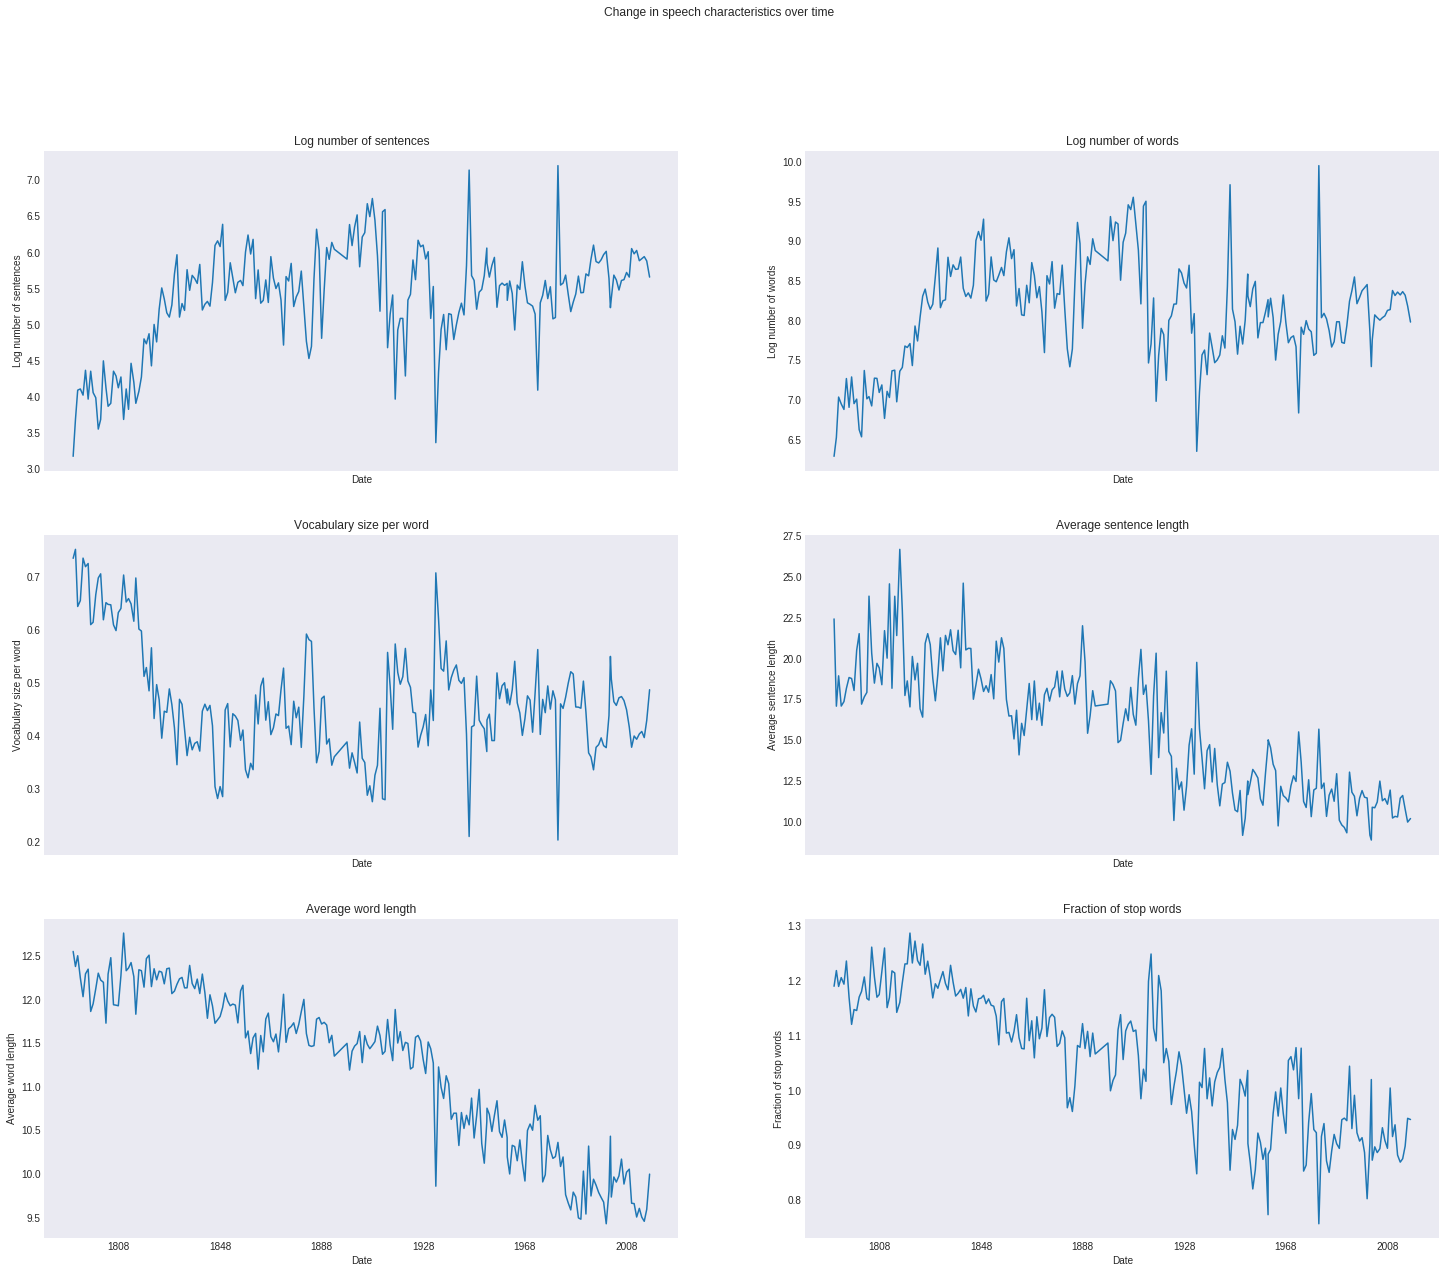

In [10]:
# plot of how changes speech over time
changeintime=pd.DataFrame(addresses['date'])
changeintime['n_sent']=np.log(addresses.n_sent)
changeintime['n_words']=np.log(addresses.n_words)
changeintime['n_words_pervocb']= (addresses.n_uwords) / (addresses.n_words)
changeintime['avgsent_length']= (addresses.n_words) / (addresses.n_sent)
changeintime['avgword_length']= (addresses.n_chars) / (addresses.n_words)
changeintime['fra_stopword']= (addresses.n_words_all - addresses.n_words) / addresses.n_words

changeintime.index= changeintime.date
changeintime = changeintime.drop('date',axis=1)

fig,axes= plt.subplots(3,2,figsize=(25,20), sharex= True)
fig.suptitle('Change in speech characteristics over time')

axes[0,0].plot_date(x=changeintime.index, y= changeintime.n_sent, linestyle='solid', marker='None')
axes[0,0].set_title('Log number of sentences')
axes[0,0].set_ylabel("Log number of sentences")
axes[0,0].set_xlabel("Date")
axes[0,1].plot_date(x=changeintime.index, y= changeintime.n_words, linestyle='solid', marker='None')
axes[0,1].set_title('Log number of words')
axes[0,1].set_ylabel("Log number of words")
axes[0,1].set_xlabel("Date")
axes[1,0].plot_date(x=changeintime.index, y= changeintime.n_words_pervocb, linestyle='solid', marker='None')
axes[1,0].set_title('Vocabulary size per word')
axes[1,0].set_ylabel("Vocabulary size per word")
axes[1,0].set_xlabel("Date")
axes[1,1].plot_date(x=changeintime.index, y= changeintime.avgsent_length, linestyle='solid', marker='None')
axes[1,1].set_title('Average sentence length')
axes[1,1].set_ylabel("Average sentence length")
axes[1,1].set_xlabel("Date")
axes[2,0].plot_date(x=changeintime.index, y= changeintime.avgword_length, linestyle='solid', marker='None')
axes[2,0].set_title('Average word length')
axes[2,0].set_ylabel("Average word length")
axes[2,0].set_xlabel("Date")
axes[2,1].plot_date(x=changeintime.index, y= changeintime.fra_stopword, linestyle='solid', marker='None')
axes[2,1].set_title('Fraction of stop words')
axes[2,1].set_ylabel("Fraction of stop words")
axes[2,1].set_xlabel("Date")

plt.savefig("fig/speech_changes.png")

These charts clearly suggest that the average word and average sentence lengths for the State of the Union speeches have decreased over time, as evidenced by the steady drop in their respective values on their plots. This drop is consistent with what we can expect based on historical trends of the English language. Interestingly, the fraction of stop words has decreased on average as well. Taking the log of the number of words and sentences in each speech, we can see a substantial increase for roughly the first 30 years, while the vocabulary size of each word experienced the opposite. After this period, there is a great deal of variation so we are unable to discern a clear pattern in that data.

Now for the distributions by president

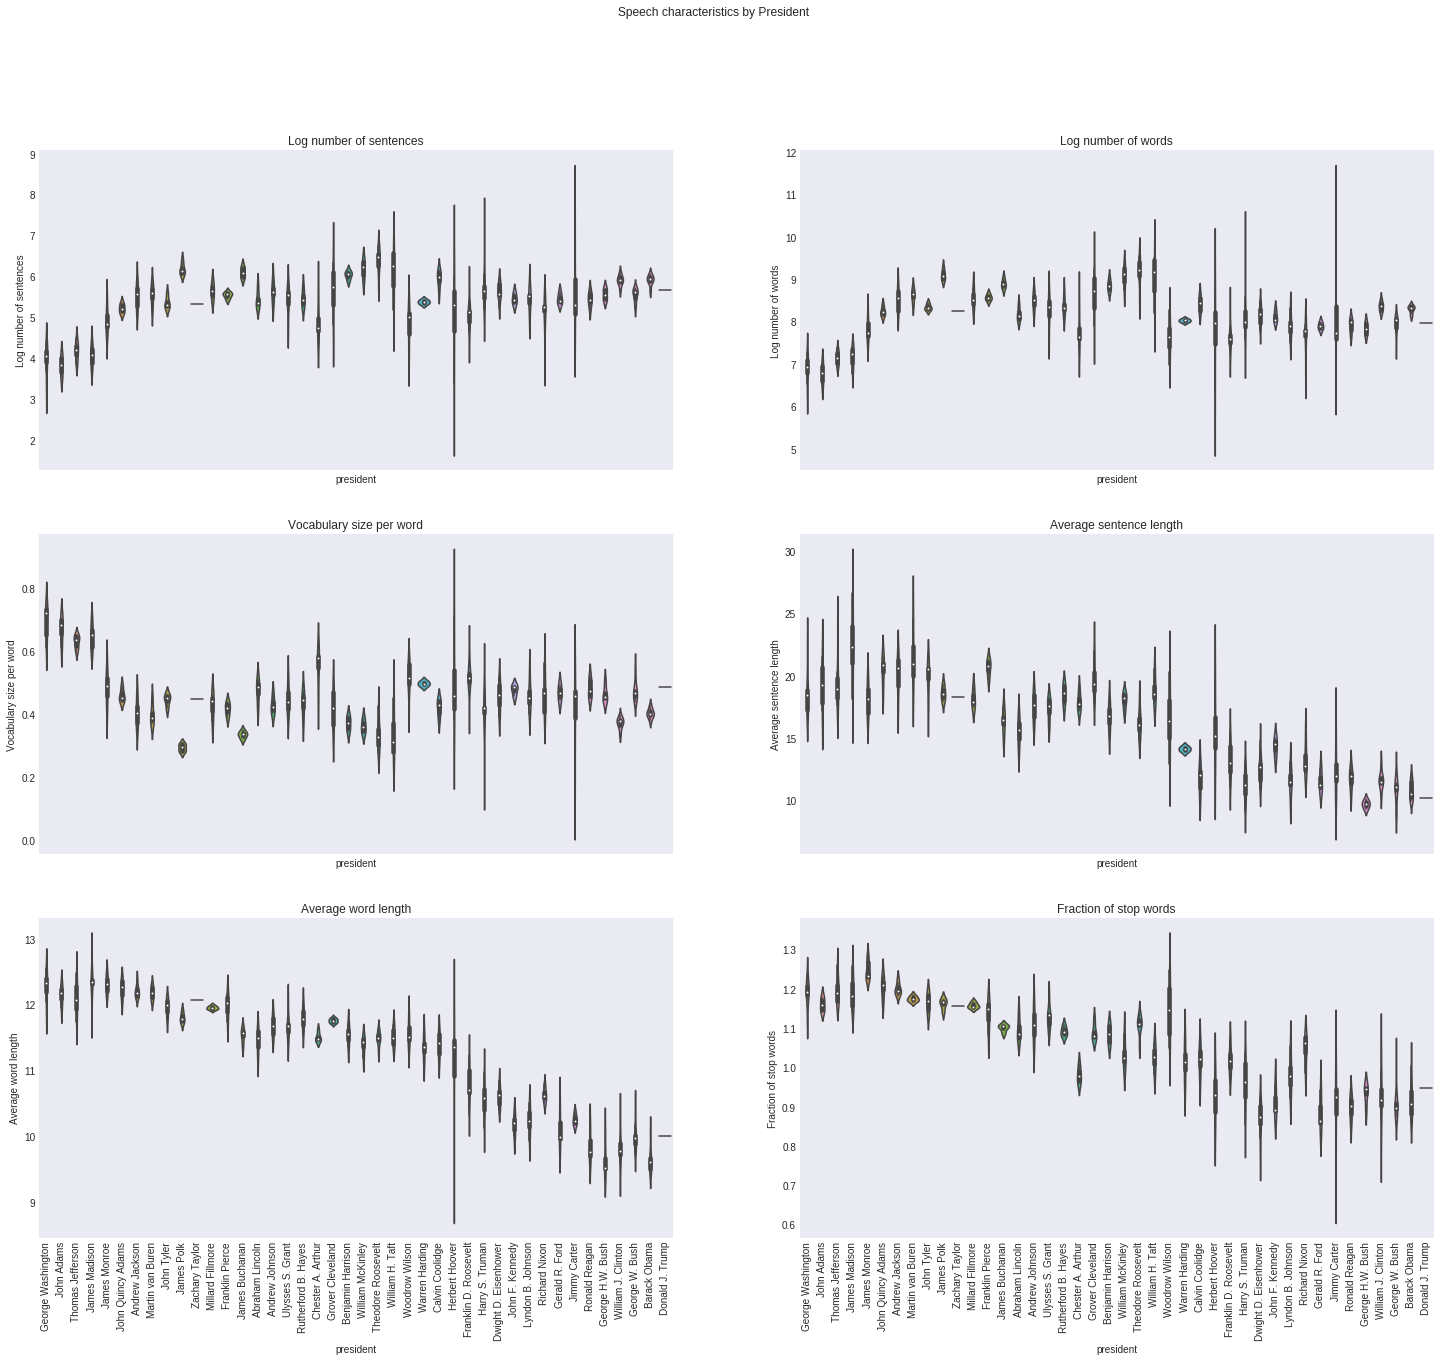

In [11]:
# violin plots by president instead of over time
presidentdis= pd.DataFrame(addresses.president)
presidentdis['n_sent']=np.log(addresses.n_sent)
presidentdis['n_words']=np.log(addresses.n_words)
presidentdis['n_words_pervocb']= (addresses.n_uwords) / (addresses.n_words)
presidentdis['avgsent_length']= (addresses.n_words) / (addresses.n_sent)
presidentdis['avgword_length']= (addresses.n_chars) / (addresses.n_words)
presidentdis['fra_stopword']= (addresses.n_words_all - addresses.n_words) / addresses.n_words

fig,axes= plt.subplots(3,2,figsize=(25,20), sharex= True)
fig.suptitle('Speech characteristics by President')

sns.violinplot(x='president', y='n_sent', data= presidentdis , ax=axes[0,0])
axes[0,0].set_title('Log number of sentences')
axes[0,0].set_ylabel("Log number of sentences")
axes[0,0].set_xlabel("president")
plt.setp( axes[0,0].xaxis.get_majorticklabels(), rotation=90)

sns.violinplot(x='president', y='n_words', data= presidentdis , ax=axes[0,1])
axes[0,1].set_title('Log number of words')
axes[0,1].set_ylabel("Log number of words")
axes[0,1].set_xlabel("president")
plt.setp( axes[0,1].xaxis.get_majorticklabels(), rotation=90)

sns.violinplot(x='president', y='n_words_pervocb', data= presidentdis , ax=axes[1,0])
axes[1,0].set_title('Vocabulary size per word')
axes[1,0].set_ylabel("Vocabulary size per word")
axes[1,0].set_xlabel("president")
plt.setp( axes[1,0].xaxis.get_majorticklabels(), rotation=90)

sns.violinplot(x='president', y='avgsent_length', data= presidentdis , ax=axes[1,1])
axes[1,1].set_title('Average sentence length')
axes[1,1].set_ylabel("Average sentence length")
axes[1,1].set_xlabel("president")
plt.setp( axes[1,1].xaxis.get_majorticklabels(), rotation=90)

sns.violinplot(x='president', y='avgword_length', data= presidentdis , ax=axes[2,0])
axes[2,0].set_title('Average word length')
axes[2,0].set_ylabel("Average word length")
axes[2,0].set_xlabel("president")
plt.setp( axes[2,0].xaxis.get_majorticklabels(), rotation=90)

sns.violinplot(x='president', y='fra_stopword', data= presidentdis , ax=axes[2,1])
axes[2,1].set_title('Fraction of stop words')
axes[2,1].set_ylabel("Fraction of stop words")
axes[2,1].set_xlabel("president")
plt.setp( axes[2,1].xaxis.get_majorticklabels(), rotation=90)

plt.savefig("fig/speech_characteristics.png");

By changing the x axis from time to presidents, we are able to see the data more discretely in that it is easier to see the data as partitions based on each president's induvidual speeches frozen in time. Displaying the previous plots as violin plot also revealed one particular president's speeches as an outlier - Herbert Hoover. Digging into the text of his speeches, we noticed that he tended to reference numbers and figures in his speeches far more often than other presidents, which led to the glaring distinction in the data for the average length and number of characters in each word. The violin plots also reveal flat lines for Zachary Taylor and Donald Trump due to the dataset only containing 1 speech for each of them, whereas the other presidents had multiple speeches. 

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [12]:
addresses.to_hdf('results/df2.h5', 'addresses')
with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words # will contain the set of unique, stemmed words for each speech
    db['speeches_cleaned'] = speeches_cleaned # stemmed/cleaned versions of each speech, without collapsing into unique word sets